# Titanic Dataset

Titanic dataset fetched from kaggle: https://www.kaggle.com/c/titanic

The goal is to correctly predict if a passenger survived the titain shipwreck.

Below is a walkthrough of imploying EDA and scikit-learn classification algorithms to predict results.

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [129]:
from sklearn.model_selection import train_test_split

# Read train.csv only and create own train test files
df = pd.read_csv("data/train.csv")

# Init train and test files
y = df["Survived"]
X = df.drop(["Survived"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

train = X_train
train["Survived"] = y_train
test = X_test

# Data Overview

In [130]:
train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
105,106,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S,0
68,69,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,1
253,254,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.1000,NaN,S,0
320,321,3,"Dennis, Mr. Samuel",male,22.0,0,0,A/5 21172,7.2500,NaN,S,0
706,707,2,"Kelly, Mrs. Florence ""Fannie""",female,45.0,0,0,223596,13.5000,NaN,S,1


In [131]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 105 to 684
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  668 non-null    int64  
 1   Pclass       668 non-null    int64  
 2   Name         668 non-null    object 
 3   Sex          668 non-null    object 
 4   Age          535 non-null    float64
 5   SibSp        668 non-null    int64  
 6   Parch        668 non-null    int64  
 7   Ticket       668 non-null    object 
 8   Fare         668 non-null    float64
 9   Cabin        157 non-null    object 
 10  Embarked     666 non-null    object 
 11  Survived     668 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 67.8+ KB


In [132]:
train.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,668.000000,668.000000,535.000000,668.000000,668.000000,668.000000,668.000000
mean,445.911677,2.305389,29.900000,0.534431,0.392216,32.373621,0.386228
std,259.966783,0.837377,14.487993,1.161739,0.822509,50.632021,0.487249
min,1.000000,1.000000,0.670000,0.000000,0.000000,0.000000,0.000000
25%,216.250000,2.000000,21.000000,0.000000,0.000000,7.925000,0.000000
50%,445.500000,3.000000,29.000000,0.000000,0.000000,14.500000,0.000000
75%,674.500000,3.000000,38.000000,1.000000,0.000000,31.275000,1.000000
max,890.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [133]:
train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            133
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          511
Embarked         2
Survived         0
dtype: int64

### Summary: 

1. Missing values in cols; Age, Cabin, Embarked
2. Numerical vars: Age,SibSp, Parch, Fare
3. Categorical vars: Sex, Embarked, Pclass

# Exploratory Data Analysis

Split columns into numerical and categorical types and visualize data to search for meaningful relationships

## Numerical Anaylsis

In [134]:
col_num = ['Age','SibSp', 'Parch', 'Fare']

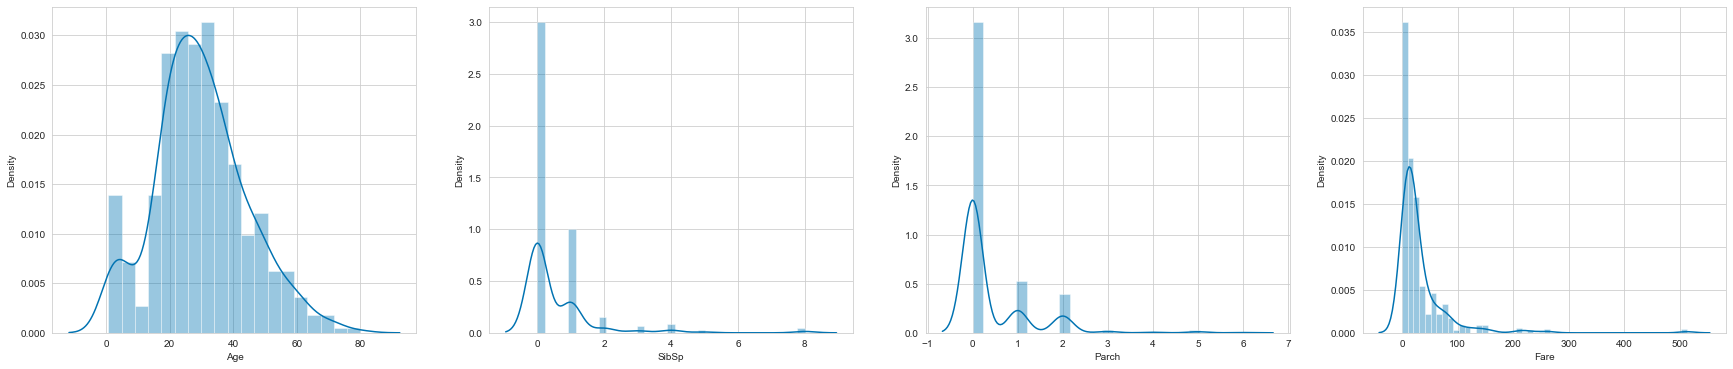

In [135]:
sns.set_palette("colorblind")
fig, ax = plt.subplots(1,4, figsize=(30,6))
for idx,col in enumerate(col_num):
    sns.distplot(train[col], ax=ax[idx])

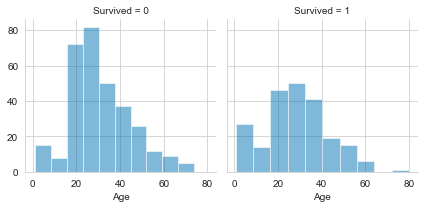

In [136]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', alpha=0.5)

In [137]:
pd.pivot_table(train, index='Survived', values=col_num)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.901899,23.208027,0.339024,0.580488
1,28.454338,46.939100,0.476744,0.461240


            Age     SibSp     Parch      Fare
Age    1.000000 -0.305921 -0.186961  0.103862
SibSp -0.305921  1.000000  0.425168  0.136919
Parch -0.186961  0.425168  1.000000  0.206725
Fare   0.103862  0.136919  0.206725  1.000000


<AxesSubplot:>

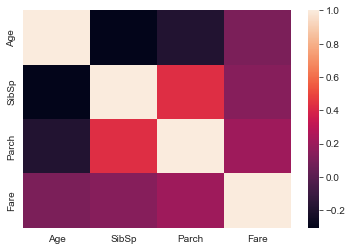

In [138]:
print(train[col_num].corr())
sns.heatmap(train[col_num].corr())

### Summary: 

1. Age is normally distributed
2. Right skew found in taking "Age" dependent on "Survived" : more younger people died
3. Fare is right skewed and needs to be normalized
4. Mean average of fare paid is higher for passengers who survived then those who died

## Categorical Analysis

In [139]:
col_cat = ['Sex', 'Embarked','Pclass']

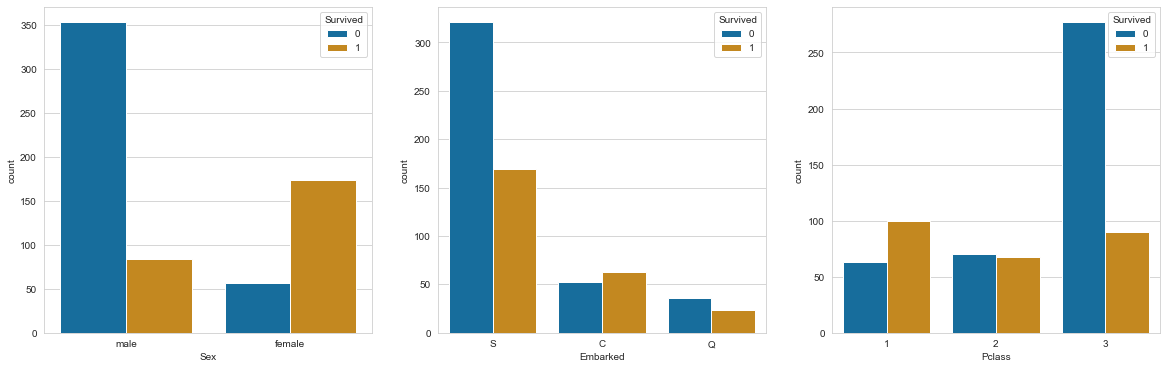

In [140]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,len(col_cat), figsize=(20,6))
for idx, col in enumerate(col_cat):
    sns.countplot(x=col, data=train, ax=ax[idx], hue="Survived")

plt.show()

### Summary: 

1. More males died then females
2. Pclass looks ordinal: 1 < 2 < 3 $\rightarrow$  coach < business < first

## Feature Engineering

From above EDA, use features for modeling [Sex, Pclass, Age, Fare]. However need to perform the following prior modeling

1. Normalize Fare to avoid overfitting
2. Impute Age NAs with the median age of associated class and gender
3. Normalize Age to avoid overfitting


### 1. Normalize Fare

In [141]:
#print(train["Fare"].describe())
coach = train[train["Fare"] < 12]
business = train[(train["Fare"] >= 12) & (train["Fare"] < 30)]
first = train[(train["Fare"] >= 30)]

def adjust_price(x):
    if x < 12: 
        return 0
    elif  30 > x >= 12:
        return 1
    elif  x >= 30:
        return 2

train["Fare"] = train["Fare"].apply(adjust_price)
test["Fare"] = test["Fare"].apply(adjust_price)

print("Coach: {0}, Business: {1}, First: {2}".format(len(coach), len(business), len(first) ))

Coach: 271, Business: 214, First: 183


<AxesSubplot:xlabel='Fare', ylabel='count'>

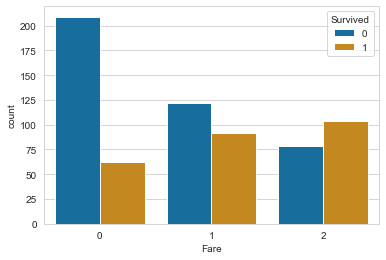

In [142]:
sns.countplot(x="Fare", data=train, hue="Survived")

### 2. Impute Age NAs

In [143]:
for x in [1,2,3]:
    for y in ["male", "female"]:
        # Train 
        mean_age = train[~pd.isnull(train["Age"]) & (train["Sex"] == y) & (train["Pclass"] == x)].Age.median()
        train.loc[pd.isnull(train["Age"]) & (train["Sex"] == y) & (train["Pclass"] == x), "Age"] = mean_age 
        
        # Test
        mean_age = test[ ~pd.isnull(test["Age"]) & (test["Sex"] == y) & (test["Pclass"] == x)].Age.median()
        test.loc[pd.isnull(test["Age"]) & (test["Sex"] == y) & (test["Pclass"] == x), "Age"] = mean_age

### 3. Normalize Age

In [144]:
def adjust_age(x):
    if x < 16: 
        return 0
    elif  30 > x >= 16:
        return 1
    elif 40 > x >= 30:
        return 2
    elif x >= 40:
        return 3
        
train["Age"] = train["Age"].apply(adjust_age)
test["Age"] = test["Age"].apply(adjust_age)

## Prepare Model  

In [145]:
train["Sex"] = train["Sex"].map({"female":0, "male":1})
test["Sex"] = test["Sex"].map({"female":0, "male":1})

In [146]:
features_col = ["Sex","Pclass", "Age", "Fare"]
target_col = ["Survived"]

X_train = train[features_col]
x_test = test[features_col]

# Classification Models


## K Nearest Neighbor

In [147]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit using x,y train
knn.fit(X_train, y_train)

# Predict y vals using x test
y_pred = knn.predict(x_test) 

# Calculate classification score
score = round( accuracy_score(y_test, y_pred) * 100, 2)
score

82.06

## Logistic Regression 

In [148]:
from sklearn.linear_model import LogisticRegression

# Define model
lr = LogisticRegression(max_iter = 2000)

# Fit using x,y train
lr.fit(X_train, y_train)

# Predict y vals using x test
y_pred = lr.predict(x_test) 

# Calculate classification score
score = round( accuracy_score(y_test, y_pred) * 100, 2)
score

78.03